# Prospective job data project

### The data project was to use the training and testing data to draw insight and make predictions of whether a business was bad or not.  There were a number of features provided.  Some were defined as discrete or continuous while others were undefined.  The response variable was binomial (0 or 1) and indicated whether a business was bad or not.


## Data Exploration


### First I used the training set provided to do some exploratory work to understand the data better and to identify the best statistical model for prediction.  I used Tableau to look at the relationship between the features and our outcome variable of "IsBad".   I found that almost 20% of the training set were "Bad" and a little over 80% were "Not Bad".  Because the number of bad and not bad businesses are not equal, I used frequency distributions to better understand the relationships between the features and IsBad.

### I looked at both the Risk Score and Quality Score to (1) determine whether it was discrete or continuous and (2)  evaluate whether there was a relationship between the Score features and IsBad.  

![Scores](Scores.png)

### I saw that the Score features both appear to be approximately normally distributed and therefore are continuous variables.  There also appears to be a relationship between both Score features and IsBad as businesses that are bad seem to have both lower Risk Scores and Quality Scores.

### Next, I looked at the number of reviews and the number of positive reviews, which were both defined as continuous variables.  Again, I see that there appears to be a relationship between both features and IsBad.  If a business is bad, it is more likely to have less positive reviews and overall number of reviews.

### Feature Engineering:  Having the number of positive reviews and the overall number of reviews allowed me to calculate the percentage of reviews that were positive.  Again, there was an apparent relationship between % of positive reviews and IsBad in that bad businesses were more likely to have a lower frequency of positive reviews.

![Business Reviews](Reviews.png)

### Next I looked at the Number of Citations, another continuous variable, and Bad status.  Because most businesses had zero citations, I limited the y axis to 20% of businesses so that the relationship between number of citations (greater than 0) and IsBad could be better understood visually.  Because there were some extreme outliers in number of citations, I also limited the number of citations to less than 90.

###  Businesses that are bad seem to have a relationship with a higher number of citations.

![Citations](Citations.png)

###  I also looked at the relationship between the discrete Risk Type features and IsBad.  I made a couple of observations.
### 1. There were a few businesses that had Risk Type values of -1 or -2.  These seemed suspicious and are most likely place holders for NaNs and were changed to "Nothing" in the data analysis.
### 2. There were a few categories withing the Risk Type features that had a clear relationship with IsBad, such as Economic Trajectory Risk 2 and 5.  The categories of Ownership Risk had a clear relationship while the categories of Previous Ownership Risk and Type of Business Risk seemed to have less of a relationship with IsBad.

![Risk](Risk.png)

### The Indices variables were not described as either discrete or continuous so I first graphed the distribution of the number of businesses by index category to get a better understanding of the data.  The Ability and Willingness Indices look like they could be exponentially distributed but the Stability Index looks like it is a discrete variable.  Without clearer evidence that they had continuous distributions, I decided to treat the Indices features as discrete.

![Index Distributions](Index Distributions.png)

### After determining that the Indices features were discrete, I explored the relationship between the features and IsBad.  I saw that there were some differences between some of the categories and IsBad.

![Indices](Indices.png)

## Training data to make a prediction on test data

### My next step was to use the training data set to test prediction algorithms to find the algorithm with the highest accuracy as determined with ROC score.  

### Import libraries for python

In [1]:
%matplotlib inline

import pandas
import numpy
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from numpy import arange
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

### Define functions to be used

In [2]:
def bin_categorical(df, cutoffPercent = .01):
    """Lumps categorcal features with frequency < cutoffPercent into 'Other'."""
    for col in df:
        sizes = df[col].value_counts(normalize = True)
        # get the names of the levels that make up less than 1% of the dataset
        values_to_delete = sizes[sizes<cutoffPercent].index
        df[col].ix[df[col].isin(values_to_delete)] = "Other"
    return df
    

def get_binary_values(data_frame):
   """encodes cateogrical features in Pandas.
   """
   all_columns = pandas.DataFrame( index = data_frame.index)
   for col in data_frame.columns:
       data = pandas.get_dummies(data_frame[col], prefix=col.encode('ascii', 'replace'))
       all_columns = pandas.concat([all_columns, data], axis=1)
   return all_columns


def find_zero_var(df):
   """finds columns in the dataframe with zero variance -- ie those
       with the same value in every observation.
   """   
   toKeep = []
   toDelete = []
   for col in df:
       if len(df[col].value_counts()) > 1:
           toKeep.append(col)
       else:
           toDelete.append(col)
       ##
   return {'toKeep':toKeep, 'toDelete':toDelete} 


def find_perfect_corr(df):
   """finds columns that are eother positively or negatively perfectly correlated (with correlations of +1 or -1), and creates a dict 
       that includes which columns to drop so that each remaining column
       is independent
   """  
   corrMatrix = df.corr()
   corrMatrix.loc[:,:] =  numpy.tril(corrMatrix.values, k = -1)
   already_in = set()
   result = []
   for col in corrMatrix:
       perfect_corr = corrMatrix[col][abs(numpy.round(corrMatrix[col],10)) >= .9].index.tolist()
       if perfect_corr and col not in already_in:
           already_in.update(set(perfect_corr))
           perfect_corr.append(col)
           result.append(perfect_corr)
   toRemove = []
   for item in result:
       toRemove.append(item[1:(len(item)+1)])
   toRemove = sum(toRemove, [])
   return {'corrGroupings':result, 'toRemove':toRemove}

### Read in training data

In [3]:
df = pandas.read_csv("train.csv")

## Data Manipulation
### I replaced data that seemed to be placeholders for NaNs as Nans, changed data type to string for the categorical variables and integer for the continuous variables, and defined the PercentPositive feature.

In [4]:
# Change data that seems suspicious to NANs
df = df.replace(-1, numpy.nan)
df = df.replace(-2, numpy.nan)
df['Index-Ability'] = df['Index-Ability'].replace(0, numpy.nan)
df['Index-Willingness'] = df['Index-Willingness'].replace(0, numpy.nan)
df['Index-Stability'] = df['Index-Stability'].replace(0, numpy.nan)

# Change data types
## Setting index variables as strings
df[['Id', 'Risk-TypeOfBusiness', 'Risk-Ownership', 'Risk-EconomicTrajectory', 'Risk-PreviousOwnership', 'Index-Ability', 'Index-Stability', 'Index-Willingness']] = df[['Id', 'Risk-TypeOfBusiness', 'Risk-Ownership', 'Risk-EconomicTrajectory', 'Risk-PreviousOwnership', 'Index-Ability', 'Index-Stability', 'Index-Willingness']].astype(str)
df[['RiskScore', 'QualityScore', 'Complaints', 'NumberOfReviews', 'PositiveReviews', 'Citations']] = df[['RiskScore', 'QualityScore', 'Complaints', 'NumberOfReviews', 'PositiveReviews', 'Citations']].astype(float)
df['isBad'] = df[ 'isBad'].astype(int)

# Feature Engineering - Create a new variable based on percent of positive reviews
df['PercentPositive'] = df.PositiveReviews / df.NumberOfReviews

# Drop any rows with all NA's
df.dropna(how = 'all', inplace = True)

## Set up explanatory and response (IsBad) variables

In [5]:
df.drop('Id', axis=1, inplace=True)
explanatory_features = [col for col in df.columns if col not in ['isBad']]
explanatory_df = df[explanatory_features]

explanatory_df.dropna(how = 'all', inplace = True)

explanatory_col_names = explanatory_df.columns

response_series = df.isBad
response_series.dropna(how = 'all', inplace = True)
response_series.index[~response_series.index.isin(explanatory_df.index)]

explanatory_df.describe()

/Users/kimkraunz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,RiskScore,QualityScore,Complaints,NumberOfReviews,PositiveReviews,Citations,PercentPositive
count,3214.00000,3214.000000,3211.000000,3214.000000,3213.000000,3212.000000,3213.000000
mean,60.62654,67.201120,1.451261,15.672682,1.643324,5.477273,0.081301
std,2.93353,6.280727,3.339610,13.267621,2.941588,14.188956,0.126138
min,50.10000,55.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,58.90000,62.600000,0.000000,5.000000,0.000000,0.000000,0.000000
50%,60.75000,66.300000,0.000000,12.000000,0.000000,0.000000,0.000000
75%,62.60000,70.700000,2.000000,22.000000,2.000000,5.000000,0.125000
max,67.10000,98.400000,59.000000,93.000000,25.000000,328.000000,0.909091


### I described the numerical data so I could have an understanding of the distribution and whether or not there were missing values.
## Prepare data for prediction model algorithms
### I processed the data by filling numerical features with NaNs with the median value of the data set, filling categorical features with NaNs with "Nothing", binning low frequency categorical variables (less than 1%) into an "Other" category, changing categorical features into binary variables, and evaluating the features for those with zero variation.

In [6]:
# 1. SPLIT DATA INTO CATEGORICAL AND NUMERIC DATA

string_features = explanatory_df.ix[:, explanatory_df.dtypes == 'object']
numeric_features = explanatory_df.ix[:, explanatory_df.dtypes != 'object']

# 2. FILL NUMERIC NANS THROUGH IMPUTATION

imputer = Imputer(missing_values='NaN', strategy='median',axis=0)
imputer.fit(numeric_features)

# impute and put back into a dataframe with the columns and indices from before
numeric_features = pandas.DataFrame(imputer.transform(numeric_features), columns=numeric_features.columns, index=numeric_features.index)

# 3. FILL CATEGORICAL NANS WITH 'NOTHING'

string_features = string_features.fillna('Nothing')

# 4. DETECT LOW-FREQUENCY LEVELS IN CATEGORICAL FEATURES AND BIN THEM UNDER 'OTHER'

string_features = bin_categorical(string_features)

# grab categories for use with the out-of-sample data
orig_categories = {}
for col in string_features.columns:
    orig_categories[col] = string_features[col].unique()

# 5. ENCODE EACH CATEGORICAL VARIABLE INTO A SEQUENCE OF BINARY VARIABLES

encoded_string_features  =  get_binary_values(string_features)

# 6. MERGE ENCODED CATEGORICAL DATA WITH YOUR NUMERIC DATA

explanatory_df = pandas.concat([numeric_features, encoded_string_features], axis=1)

# 7. REMOVE FEATURES WITH NO VARIATION

keep_delete = find_zero_var(explanatory_df)
print keep_delete

{'toKeep': ['RiskScore', 'QualityScore', 'Complaints', 'NumberOfReviews', 'PositiveReviews', 'Citations', 'PercentPositive', 'Risk-TypeOfBusiness_1.0', 'Risk-TypeOfBusiness_3.0', 'Risk-TypeOfBusiness_Other', 'Risk-Ownership_0.0', 'Risk-Ownership_1.0', 'Risk-Ownership_2.0', 'Risk-Ownership_3.0', 'Risk-Ownership_4.0', 'Risk-Ownership_Other', 'Risk-EconomicTrajectory_0.0', 'Risk-EconomicTrajectory_1.0', 'Risk-EconomicTrajectory_2.0', 'Risk-EconomicTrajectory_3.0', 'Risk-EconomicTrajectory_4.0', 'Risk-EconomicTrajectory_5.0', 'Risk-EconomicTrajectory_6.0', 'Risk-EconomicTrajectory_Other', 'Risk-PreviousOwnership_0.0', 'Risk-PreviousOwnership_1.0', 'Risk-PreviousOwnership_2.0', 'Risk-PreviousOwnership_5.0', 'Risk-PreviousOwnership_Other', 'Index-Ability_1.0', 'Index-Ability_2.0', 'Index-Ability_3.0', 'Index-Ability_4.0', 'Index-Ability_5.0', 'Index-Ability_6.0', 'Index-Ability_7.0', 'Index-Ability_8.0', 'Index-Ability_9.0', 'Index-Ability_Other', 'Index-Stability_1.0', 'Index-Stability_2.0'

### No features had zero variation.

### Next, I checked features for correlation of greater than 0.9.

In [7]:
# 8. REMOVE CORRELATED FEATURES

find_perfect_corr(explanatory_df)

{'corrGroupings': [['Risk-TypeOfBusiness_3.0',
   'Risk-Ownership_1.0',
   'Risk-TypeOfBusiness_1.0'],
  ['Risk-EconomicTrajectory_Other', 'Risk-Ownership_Other'],
  ['Index-Stability_Other', 'Index-Ability_Other']],
 'toRemove': ['Risk-Ownership_1.0',
  'Risk-TypeOfBusiness_1.0',
  'Risk-Ownership_Other',
  'Index-Ability_Other']}

### I found four sets of features that were had a correlation greater than 0.9.  I deleted one feature in each pair.  I then scaled each feature to a mean of zero and variance of one.

In [8]:
explanatory_df.drop('Risk-Ownership_1.0', axis=1, inplace=True)
explanatory_df.drop('Risk-TypeOfBusiness_1.0', axis=1, inplace=True)
explanatory_df.drop('Risk-Ownership_Other', axis=1, inplace=True)
explanatory_df.drop('Index-Ability_Other', axis=1, inplace=True)

# 9. SCALE DATA WITH ZERO MEAN AND UNIT VARIANCE

scaler = preprocessing.StandardScaler()
scaler.fit(explanatory_df)
explanatory_df = pandas.DataFrame(scaler.transform(explanatory_df), columns = explanatory_df.columns)

## Model Selection
### I decided to use F1 scores to identify the best predictive model of Random Forests, Gradient Boosting Trees, Logistic Regression, and Extra Trees.  I chose F1 because I wanted to use a score that valued true positivity (or recall).  I performed a 10-fold cross validation for each model.

In [11]:
# Random Forest
rf = RandomForestClassifier(n_estimators = 500)
f1_scores_rf = cross_val_score(rf, explanatory_df, response_series, cv=10, scoring = 'f1', n_jobs = -1)

#Gradient Boosting Tree
boosting_tree = GradientBoostingClassifier()
f1_scores_gbm = cross_val_score(boosting_tree, explanatory_df, response_series, cv=10, scoring = 'f1', n_jobs = -1)

# Neural Network
logistic_classifier = LogisticRegression()
f1_scores_lr = cross_val_score(logistic_classifier, explanatory_df, response_series, cv=10, scoring = 'f1')

# Extra Trees Classifier
et = ExtraTreesClassifier(n_estimators = 500)
f1_scores_et = cross_val_score(et, explanatory_df, response_series, cv=10, scoring = 'f1', n_jobs = -1)

print "Random Forest F1 Score:", f1_scores_rf.mean()
print "Gradient Boosting Tree F1 Score:", f1_scores_gbm.mean()
print "Logistic Regression F1 Score:", f1_scores_lr.mean()
print "Extra Trees F1 Score:", f1_scores_et.mean()

Random Forest F1 Score: 0.230642716806
Gradient Boosting Tree F1 Score: 0.274569510047
Logistic Regression F1 Score: 0.282241777999
Extra Trees F1 Score: 0.210989962494


### The Logistic Regression model had the highest F1 score and I chose to move forward with model refinement with it.

### Before I performed recursive feature elimination, I wanted to see what the sensitivity (detecting true positives) and specificity (detecting true negatives) were.


In [14]:
pred_bad = logistic_classifier.predict(explanatory_df)

from __future__ import division

number_correct = len(response_series[response_series == pred_bad])
total = len(response_series)
accuracy = number_correct / total

print "Accuracy: ", accuracy

cm = pandas.crosstab(response_series, pred_bad, rownames=['True Label'], colnames=['Predicted Label'], margins=True)

print cm

Accuracy:  0.825762289981
Predicted Label     0    1   All
True Label                      
0                2528   58  2586
1                 502  126   628
All              3030  184  3214


### Sensitivity: 126/628 = 20.1%
### Specificity: 2528/2586 = 97.8%
### Observation: Good at identifying what is not a bad business but not great at identifying what is a good business but overall is 82.6% accurate.

## Recursive Feature Elimination (RFE)
### The above models had many features due to the large amount of categorical features.  I chose to move forward with the Logistic Regression model and to determine which features could be eliminated because they didn't contribute to increasing the accuracy of the model. 

Optimal number of features :39 of 54 considered
[ 0.01548077  0.1709488   0.1667351   0.21208463  0.22343225  0.22940177
  0.23658647  0.23422217  0.25473265  0.24922697  0.26111623  0.26435289
  0.26451332  0.27093006  0.27420062  0.2771072   0.27367101  0.27403102
  0.27329401  0.27321674  0.27823115  0.27596951  0.27208229  0.27654582
  0.27502672  0.2798535   0.27779476  0.27787118  0.27573738  0.27595913
  0.27557686  0.27728418  0.27953613  0.27753458  0.28043309  0.28043309
  0.28403218  0.28425938  0.28473982  0.28473982  0.28133677  0.2771417
  0.27988609  0.27953041  0.27953041  0.28298073  0.28258928  0.28224178
  0.28224178  0.28224178  0.28224178  0.28224178  0.28224178  0.28224178]
Index([u'RiskScore', u'QualityScore', u'Complaints', u'NumberOfReviews',
       u'Citations', u'PercentPositive', u'Risk-TypeOfBusiness_Other',
       u'Risk-Ownership_0.0', u'Risk-Ownership_2.0', u'Risk-Ownership_4.0',
       u'Risk-EconomicTrajectory_1.0', u'Risk-EconomicTrajectory_2.0',
    

/Users/kimkraunz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


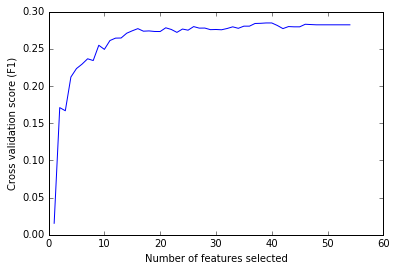

In [15]:
## set up the estimator
rfe_cv = RFECV(estimator=logistic_classifier, step=1, cv=10,
              scoring='f1', verbose = 1)
rfe_cv.fit(explanatory_df, response_series)

print "Optimal number of features :{0} of {1} considered".format(rfe_cv.n_features_,len(explanatory_df.columns))
print rfe_cv.grid_scores_

# pull out the features used
features_used = explanatory_df.columns[rfe_cv.get_support()]
print features_used  

## plot out the results
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (F1)")
plt.plot(range(1, len(rfe_cv.grid_scores_) + 1), rfe_cv.grid_scores_)
plt.show()

### I identified the features that would give the highest accuracy moving forward without diluting the Logistic Regression model.  I did not see a large increase in the F1 scorea after around 18 features were used.

### Note: I was curious because some of the features identified in RFE did not seem as important as others that were eliminated.  I ran the Logistic Regression Model with only the features that had an importance greater than 1% and got roughly the same F1 score.

## **Grid Search to identify optimal parameters**
### I performed a grid search to identify the learning rate, subsampling rate and number of estimators that would give me the highest accuracy for my model.

In [16]:
# Use only features indentified in RFE

best_features = explanatory_df[features_used]

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
lr_grid = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, scoring = 'f1')
GridSearchCV(cv=None,
       estimator=LogisticRegression(C=1.0, intercept_scaling=1, dual=False, fit_intercept=True,
          penalty='l2', tol=0.0001),
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

lr_grid.fit(best_features, response_series)

print lr_grid.best_params_
print lr_grid.best_score_

# PULL OUT THE WINNING ESTIMATOR
best_lr_grid = lr_grid.best_estimator_

{'C': 0.001}
0.32604999092


### With an optimized model, I wanted to see how the sensitivity and specificity had changed.

In [17]:
pred_bad = best_lr_grid.predict(best_features)

from __future__ import division

number_correct = len(response_series[response_series == pred_bad])
total = len(response_series)
accuracy = number_correct / total

print "Accuracy: ", accuracy

cm = pandas.crosstab(response_series, pred_bad, rownames=['True Label'], colnames=['Predicted Label'], margins=True)

print cm

Accuracy:  0.824206596142
Predicted Label     0    1   All
True Label                      
0                2514   72  2586
1                 493  135   628
All              3007  207  3214


### My accuracy stayed roughly the same at 82.4%.  Unfortunately it is a small increase from the baseline accuracy of 80.4%
### Sensitivity: 135/628 = 21.5%
### Specificity: 72/2514 = 97.2%
###  With model optimization, I was able to increase the model's ability to identify bad businesses with a slight decrease in it's ability to identify businesses that aren't bad.

## Making predictions to the test data
### I then read in the test data and repeated the above data manipulation and processing steps.

In [18]:
# Import testing df
t_df = pandas.read_csv("test.csv")
test_df = t_df

############# DATA MANIPULATION  ###################

# Change data that seems suspicious to NANs
test_df = test_df.replace(-1, numpy.nan)
test_df = test_df.replace(-2, numpy.nan)
test_df['Index-Ability'] = test_df['Index-Ability'].replace(0, numpy.nan)
test_df['Index-Willingness'] = test_df['Index-Willingness'].replace(0, numpy.nan)
test_df['Index-Stability'] = test_df['Index-Stability'].replace(0, numpy.nan)

# Change data types
## Setting index variables as strings
test_df[['Id', 'Risk-TypeOfBusiness', 'Risk-Ownership', 'Risk-EconomicTrajectory', 'Risk-PreviousOwnership', 'Index-Ability', 'Index-Stability', 'Index-Willingness']] = test_df[['Id', 'Risk-TypeOfBusiness', 'Risk-Ownership', 'Risk-EconomicTrajectory', 'Risk-PreviousOwnership', 'Index-Ability', 'Index-Stability', 'Index-Willingness']].astype(str)
test_df[['RiskScore', 'QualityScore', 'Complaints', 'NumberOfReviews', 'PositiveReviews', 'Citations']] = test_df[['RiskScore', 'QualityScore', 'Complaints', 'NumberOfReviews', 'PositiveReviews', 'Citations']].astype(float)

# Created the PercentPostive feature
test_df['PercentPositive'] = test_df.PositiveReviews / test_df.NumberOfReviews

# Drop any rows with all NA's
test_df.dropna(how = 'all', inplace = True)

# Set up explanatory and response features
test_df.drop('Id', axis=1, inplace=True)
test_explanatory_df = test_df

test_explanatory_df.dropna(how = 'all', inplace = True)

test_explanatory_col_names = test_explanatory_df.columns

test_explanatory_df.describe()

# 1. SPLIT DATA INTO CATEGORICAL AND NUMERIC DATA

test_string_features = test_explanatory_df.ix[:, test_explanatory_df.dtypes == 'object']
test_numeric_features = test_explanatory_df.ix[:, test_explanatory_df.dtypes != 'object']


# 2. FILL NUMERIC NANS THROUGH IMPUTATION

test_numeric_features = pandas.DataFrame(imputer.transform(test_numeric_features), columns = test_numeric_features.columns)

# 3. FILL CATEGORICAL NANS WITH 'NOTHING'

test_string_features = test_string_features.fillna('Nothing')

# for each string feature, if there is a value that is not in the original dataset, make it 'other'.
for col in test_string_features:
    test_string_features[col].ix[~test_string_features[col].isin(orig_categories[col])] = "Other"

test_encoded_string_features  =  get_binary_values(test_string_features)

# post-encoding, add any dummy features that were in the original
for col in encoded_string_features:
    if col not in test_encoded_string_features:
        test_encoded_string_features[col] = 0


# REORDER COLUMNS TO MATCH ORIGINAL

test_encoded_string_features = test_encoded_string_features[encoded_string_features.columns]

# COMBINE NUMERIC AND STRING FEATURES
test_explanatory_df = pandas.concat([test_numeric_features, test_encoded_string_features], axis=1)

# REMOVE CORELATED FEATURES
  
test_explanatory_df.drop('Risk-Ownership_1.0', axis=1, inplace=True)
test_explanatory_df.drop('Risk-TypeOfBusiness_1.0', axis=1, inplace=True)
test_explanatory_df.drop('Risk-Ownership_Other', axis=1, inplace=True)
test_explanatory_df.drop('Index-Ability_Other', axis=1, inplace=True)

# SCALE
test_explanatory_df = pandas.DataFrame(scaler.transform(test_explanatory_df),columns=test_explanatory_df.columns,index=test_explanatory_df.index)

# LIMIT EXPLANATORY DATAFRAME TO BEST FEATURES (FROM RFE)

test_best_features = test_explanatory_df[features_used]

## Fit the trained Logistic Regression model to the test data

In [19]:
# TEST DATA USING OPTIMIZED LOGISTIC REGRESSION MODEL DATA

pred_test = pandas.DataFrame(best_lr_grid.predict(test_best_features), columns = ['IsBad'])

pred_test_df = pandas.concat([t_df.Id, pred_test], axis=1)

# WRITE PREDICTIONS TO CSV
pred_test_df.to_csv('kraunz_test_predictions.csv')

## Conclusions and observations
###  I was able to identify the best classifier model using F1 scoring, which values sensitivity and specificity, as the Logistic Regression model.  I refined the model using recursive feature elimination and grid search to optimize it.  The accuracy of the final model is decent and the specificity is high but the sensitivity could still be improved (~20%), especially since it was a modest increase in accuracy over the baseline accuracy.  Interestingly, almost 20% of the training data set were "Bad", while only a little over 7% of the testing data set were predicted to be "Bad".